# 7.4 합성곱/풀링 계층 구현하기
## 7.4.1 4차원 배열
: CNN 계층 사이를 흐르는 데이터<br/>
: (10, 1, 28, 28) - 데이터, 채널, 높이, 너비

In [1]:
import numpy as np

x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

In [2]:
x[0].shape

(1, 28, 28)

In [3]:
x[1].shape

(1, 28, 28)

In [8]:
x[0,0]

array([[2.86018757e-01, 1.42138738e-01, 3.32036445e-01, 2.85604740e-01,
        2.57397724e-01, 3.36001433e-02, 9.87256824e-01, 7.42138639e-01,
        7.29441008e-01, 1.85726016e-01, 2.20151476e-01, 4.15639416e-01,
        4.68282968e-01, 3.76265338e-01, 5.17840724e-01, 3.87685467e-02,
        9.20892037e-01, 9.67828269e-01, 9.28074092e-01, 1.83845433e-01,
        9.69215244e-01, 6.89370746e-01, 8.04499676e-01, 2.71983591e-01,
        3.64934225e-01, 6.82068216e-01, 8.92972974e-01, 2.02072531e-03],
       [3.14793180e-01, 3.32309933e-01, 1.68068502e-02, 7.88918637e-02,
        6.23639350e-01, 3.99630516e-01, 8.76649412e-01, 3.14618576e-02,
        7.42605171e-01, 7.15416588e-01, 4.51483556e-01, 4.88443436e-01,
        7.72872851e-01, 4.65353770e-02, 4.90596022e-01, 4.18615941e-01,
        2.95825447e-01, 7.11577559e-01, 7.08767520e-01, 2.19670946e-02,
        2.81752662e-01, 2.71207208e-01, 5.63484390e-01, 9.89304168e-01,
        7.79310461e-01, 8.60788485e-01, 4.28998612e-01, 2.34949

## 7.4.2 im2col로 데이터 전개하기
: 입력데이터를 필터링하기 좋게 전개하는 함수<br/>
: Numpy에서는 for문을 통한 원소 접근은 바람직하지 않다.<br/>
: 필터를 적용하는 영역을 2차원으로 전개<br/>
: 영역이 겹치는 경우 전개했을 때, 원소 수가 증가해서 메모리를 많이 소비하는 단점이 있다.<br/>
: 하지만 행렬 계산 라이브러리 때문에 연산을 빨리할 수 있고, 효율을 높일 수 있다.<br/>
: 마지막으로 연산 결과물을 4차원으로 변형하는 것이 합성곱 계층의 구현 흐름 (그림 7-19)

## 7.4.3 합성곱 계층 구현하기
: (1단계) 이미지 평탄화<br/>
: 전개된 이미지 설명

In [5]:
import sys, os
sys.path.append(os.pardir)
sys.path.append(os.pardir + '/src')

from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride = 1, pad = 0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride = 1, pad = 0)
print(col2.shape)

(9, 75)
(90, 75)


: (2단계) 합성곱 계층 구현

In [6]:
class Convolution:
    
    def __init__(self, W, b, stride = 1, pad = 0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        return out

## 7.4.4 풀링 계층 구현하기

: 채널 쪽이 독립적

In [7]:
class Pooling:
    
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out

# 7.5 CNN 구현하기
: 앞서 구현한 합성곱 계층과 폴링 계층을 조합하여 CNN 구현
## SimpleConvNet

In [10]:
import pickle

from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

class SimpleConvNet:
    
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size) 
        
        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()
        
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
    
    
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]
    
    
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)
            
            
    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

MNIST 데이터 학습
## trainConvNet

In [9]:
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 10

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

train loss:2.2991365062851963
=== epoch:1, train acc:0.099, test acc:0.088 ===
train loss:2.2971986639091067
train loss:2.2937726349205185
train loss:2.2885589882183663
train loss:2.277781255232904
train loss:2.267406802992254
train loss:2.2551011858700565
train loss:2.2324261648794974
train loss:2.2129387284028166
train loss:2.1768263534530052
train loss:2.160874908139011
train loss:2.0804182110687273
train loss:2.0801311827407085
train loss:2.0300631475366306
train loss:1.9706791028321264
train loss:1.952866399501128
train loss:1.8370283819651823
train loss:1.7720456767226478
train loss:1.6791756984661392
train loss:1.6317359447003446
train loss:1.54323798164839
train loss:1.5148972843949182
train loss:1.3673405540204455
train loss:1.364037386061838
train loss:1.334053929307156
train loss:1.1824289648589106
train loss:1.1575528972240077
train loss:0.9947272884113108
train loss:1.0029321569629237
train loss:0.9171103381934627
train loss:0.822857748043372
train loss:0.7967263552780282


train loss:0.39631335877316426
train loss:0.2878443437704456
train loss:0.18512288707946453
train loss:0.2694793259880066
train loss:0.1912845319217999
train loss:0.21153196500544783
train loss:0.37611662187201367
train loss:0.21028603803757118
train loss:0.29365224850187804
train loss:0.15957184738789154
train loss:0.25078913079009596
train loss:0.12542317253419263
train loss:0.18881963464609872
train loss:0.15725230829344208
train loss:0.2925955473573014
train loss:0.17038091330612812
train loss:0.2694107824937441
train loss:0.21502740496257317
train loss:0.15874455755954042
train loss:0.2283162924806647
train loss:0.19210053181233885
train loss:0.17063072658929473
train loss:0.20511858955615242
train loss:0.20635064606824907
train loss:0.17075906475323432
train loss:0.22533500598203002
train loss:0.1759179563890327
train loss:0.1699947956989163
train loss:0.26812511579349424
train loss:0.10508929330941194
train loss:0.10379132008353548
train loss:0.23779641114372208
train loss:0.085

<Figure size 640x480 with 1 Axes>

# 7.6 CNN 시각화하기

: 필터의 모습을 보면 가로 방향의 에지나 세로 방향의 에지에 영향을 받는다는 사실을 알 수 있다.

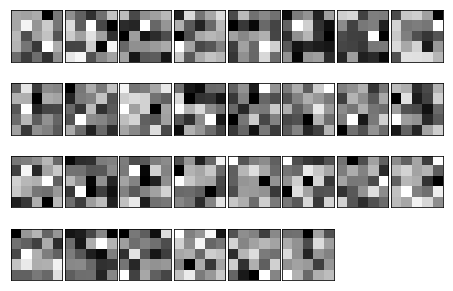

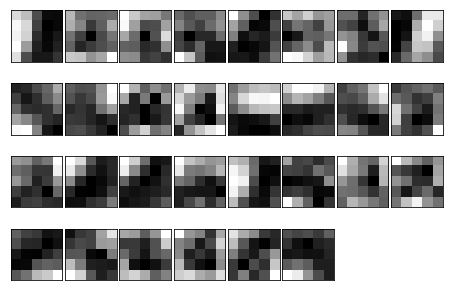

In [12]:
def filter_show(filters, nx=8, margin=3, scale=10):

    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])

# 7.7 대표적인 CNN
## 7.7.1 LeNet
: 손글씨 숫자를 인식하는 네트워크, 1998에 제안<br/>
: (그림 7-27)<br/>
: 단순한 합성곱 계층과 풀링 계층의 반복, 마지막에 완전연결 계층<br/>
: 활성화 함수로 Sigmoid 사용<br/>
: Sigmoid를 사용하는 경우, Gradient Vanishing 발생할 수 있어, 요즘은 ReLU 사용<br/>
: 32x32x1 이미지
## 7.7.2 AlexNet
: ImageNet 영상 데이터 베이스를 기반으로 한 화상 인식 대회인 ILSVRC 2012에서 우승한 CNN 구조<br/>
: 구조는 LeNet과 비슷<br/>
: 활성화 함수 ReLU 사용, LRN이라는 국소적 정규화를 실시하는 계층 이용, 드롭아웃 사용<br/>
: 2개의 병렬 GPU를 기반으로한 병렬 구조<br/>
: 224x224x3 이미지<br/>
: GPU-1은 컬러와 상관없는 정보, GPU-2는 컬러와 상관있는 정보<br/>
![이미지](images.jpeg)
